In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# Ensure timm is installed for MobileViT
try:
    import timm
except ImportError:
    print("timm library not found. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "timm"])
    import timm

# Check for GPU (M1/M2/M3 Mac Optimization: 'mps', NVIDIA: 'cuda', else 'cpu')
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Apple Silicon ")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("NVIDIA ")
else:
    DEVICE = torch.device("cpu")
    print("CPU")


MAIN_DATASET_PATH = "../NNATT dataset" 


# Derive classes from folders in MAIN_DATASET_PATH
# Filter only directories and ignore hidden ones
CLASS_NAMES = [d for d in os.listdir(MAIN_DATASET_PATH) 
               if os.path.isdir(os.path.join(MAIN_DATASET_PATH, d)) and not d.startswith('.')]
CLASS_NAMES.sort()
LOCAL_CLASSES = CLASS_NAMES

# Define Labels Mapping
label_map = {name: i for i, name in enumerate(CLASS_NAMES)}
print(f"Classes: {label_map}")

/Users/tanmaytalreja/.pyenv/versions/myproject-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Apple Silicon 
Classes: {'Albit': 0, 'Calcite': 1, 'Dolomit': 2, 'Feldspat': 3, 'Quarz': 4, 'Rhodocrosite': 5, 'Tile': 6}


In [2]:
# --- 2. Data Loading & Preprocessing ---

# Image Transformations
# Resize to 224x224, Convert to Tensor, Normalize with ImageNet stats
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_paths = []
labels = []

# 1. Scan Local Folders
print("Scanning local folders...")
for cls_name in LOCAL_CLASSES:
    

    # Take images only from the 30fps folder inside the mineral folder
    search_pattern = os.path.join(MAIN_DATASET_PATH, cls_name, '30fps', '*.bmp')
    found_files = glob.glob(search_pattern, recursive=False)
    
    
    found_files = [f for f in found_files if not f.endswith('.csv')]
    
    print(f"  Found {len(found_files)} images for {cls_name}")
    for f in found_files:
        image_paths.append(f)
        labels.append(label_map[cls_name])


print(f"\nTotal dataset size: {len(image_paths)} images")

if len(image_paths) == 0:
    raise ValueError("No images found! Please check your directory structure.")

# Custom Dataset Class
class MineralDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        try:
            
            image = Image.open(path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading {path}: {e}")
            
            return torch.zeros(3, 224, 224), label

# (80% Train, 20% Test)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Testing samples: {len(test_paths)}")

# Create Datasets and DataLoaders
train_dataset = MineralDataset(train_paths, train_labels, transform=transform)
test_dataset = MineralDataset(test_paths, test_labels, transform=transform)


train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False, 
    pin_memory=False
)

Scanning local folders...
  Found 711 images for Albit
  Found 704 images for Calcite
  Found 768 images for Dolomit
  Found 752 images for Feldspat
  Found 736 images for Quarz
  Found 736 images for Rhodocrosite
  Found 720 images for Tile

Total dataset size: 5127 images
Training samples: 4101
Testing samples: 1026


In [3]:
# --- 3. Model Definitions & Training Logic ---

NUM_CLASSES = len(CLASS_NAMES)

# Model A: ResNet50
def get_resnet50(num_classes):
    print("Loading ResNet50...")
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Replace the final Fully Connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# Model B: MobileViT (via timm)
def get_mobile_vit(num_classes):
    print("Loading MobileViT...")
    # using 'mobilevit_xs' (Extra Small). Other options: 'mobilevit_s', 'mobilevit_xxs'
    model = timm.create_model('mobilevit_xs', pretrained=True, num_classes=num_classes)
    return model

# Deep Learning Training Function
def train_dl_model(model, loader, criterion, optimizer, epochs=5, model_name="Model"):
    model.to(DEVICE)
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        
        pbar = tqdm(loader, desc=f"[{model_name}] Epoch {epoch+1}/{epochs}", unit="batch")
        
        for images, labels in pbar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
            pbar.set_postfix({'Loss': f'{running_loss/len(loader):.4f}', 'Acc': f'{100 * correct / total:.2f}%'})

        # Check if accuracy reached 100%
        epoch_acc = 100 * correct / total
        if epoch_acc >= 100.0:
            print(f"\n{model_name} reached 100% accuracy! Stopping training early.")
            break


def evaluate_dl_model(model, loader):
    model.to(DEVICE)
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            
    return all_preds

# Helper to flatten data for Random Forest
def get_flattened_data(dataset):
    print("Flattening data for Random Forest (this may take a moment)...")
    loader = DataLoader(dataset, batch_size=8, shuffle=False)
    features_list = []
    labels_list = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Flattening"):
            # Flatten: [Batch, 3, 224, 224] -> [Batch, 3*224*224]
            flat = images.view(images.size(0), -1).numpy()
            features_list.append(flat)
            labels_list.append(labels.numpy())
            
    return np.concatenate(features_list), np.concatenate(labels_list)

In [4]:
# --- 4. Training & Execution ---

results = {}     
predictions = {} 

#
criterion = nn.CrossEntropyLoss()


# 1. Train MobileViT

mobilevit_model = get_mobile_vit(NUM_CLASSES)
optimizer_mobilevit = optim.Adam(mobilevit_model.parameters(), lr=1e-4)

print("\nStarting MobileViT Training...")
train_dl_model(mobilevit_model, train_loader, criterion, optimizer_mobilevit, epochs=5, model_name="MobileViT")

# Evaluate MobileViT
print("Evaluating MobileViT...")
mobilevit_preds = evaluate_dl_model(mobilevit_model, test_loader)
mobilevit_acc = accuracy_score(test_labels, mobilevit_preds)
results['MobileViT'] = mobilevit_acc
predictions['MobileViT'] = mobilevit_preds
print(f"MobileViT Test Accuracy: {mobilevit_acc:.4f}")


# 2. Train ResNet50 (CNN)

resnet_model = get_resnet50(NUM_CLASSES)
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=1e-4)

print("\nStarting ResNet50 Training...")
train_dl_model(resnet_model, train_loader, criterion, optimizer_resnet, epochs=5, model_name="ResNet50")

# Evaluate ResNet50
print("Evaluating ResNet50...")
resnet_preds = evaluate_dl_model(resnet_model, test_loader)
resnet_acc = accuracy_score(test_labels, resnet_preds)
results['ResNet50'] = resnet_acc
predictions['ResNet50'] = resnet_preds
print(f"ResNet50 Test Accuracy: {resnet_acc:.4f}")


# 3. Train Random Forest (Classical)

print("\nStarting Random Forest Training...")
# Flatten data
X_train_flat, y_train_flat = get_flattened_data(train_dataset)
X_test_flat, y_test_flat = get_flattened_data(test_dataset)

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
print("Fitting Random Forest...")
rf_clf.fit(X_train_flat, y_train_flat)

# Evaluate Random Forest
print("Evaluating Random Forest...")
rf_preds = rf_clf.predict(X_test_flat)
rf_acc = accuracy_score(y_test_flat, rf_preds)
results['Random Forest'] = rf_acc
predictions['Random Forest'] = rf_preds
print(f"Random Forest Test Accuracy: {rf_acc:.4f}")

Loading MobileViT...

Starting MobileViT Training...


[MobileViT] Epoch 4/5: 100%|██████████| 513/513 [02:22<00:00,  3.60batch/s, Loss=0.0215, Acc=100.00%]



MobileViT reached 100% accuracy! Stopping training early.
Evaluating MobileViT...
MobileViT Test Accuracy: 1.0000
Loading ResNet50...

Starting ResNet50 Training...


[ResNet50] Epoch 2/5: 100%|██████████| 513/513 [03:38<00:00,  2.35batch/s, Loss=0.0009, Acc=100.00%]



ResNet50 reached 100% accuracy! Stopping training early.
Evaluating ResNet50...
ResNet50 Test Accuracy: 1.0000

Starting Random Forest Training...
Flattening data for Random Forest (this may take a moment)...


Flattening: 100%|██████████| 513/513 [00:29<00:00, 17.21it/s]


Flattening data for Random Forest (this may take a moment)...


Flattening: 100%|██████████| 129/129 [00:07<00:00, 17.40it/s]


Fitting Random Forest...
Evaluating Random Forest...
Random Forest Test Accuracy: 1.0000



--- Final Results ---
MobileViT: 1.0000
ResNet50: 1.0000
Random Forest: 1.0000

🏆 Best Performing Model: MobileViT (1.0000)

Classification Report for MobileViT:
              precision    recall  f1-score   support

       Albit       1.00      1.00      1.00       142
     Calcite       1.00      1.00      1.00       141
     Dolomit       1.00      1.00      1.00       154
    Feldspat       1.00      1.00      1.00       151
       Quarz       1.00      1.00      1.00       147
Rhodocrosite       1.00      1.00      1.00       147
        Tile       1.00      1.00      1.00       144

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026



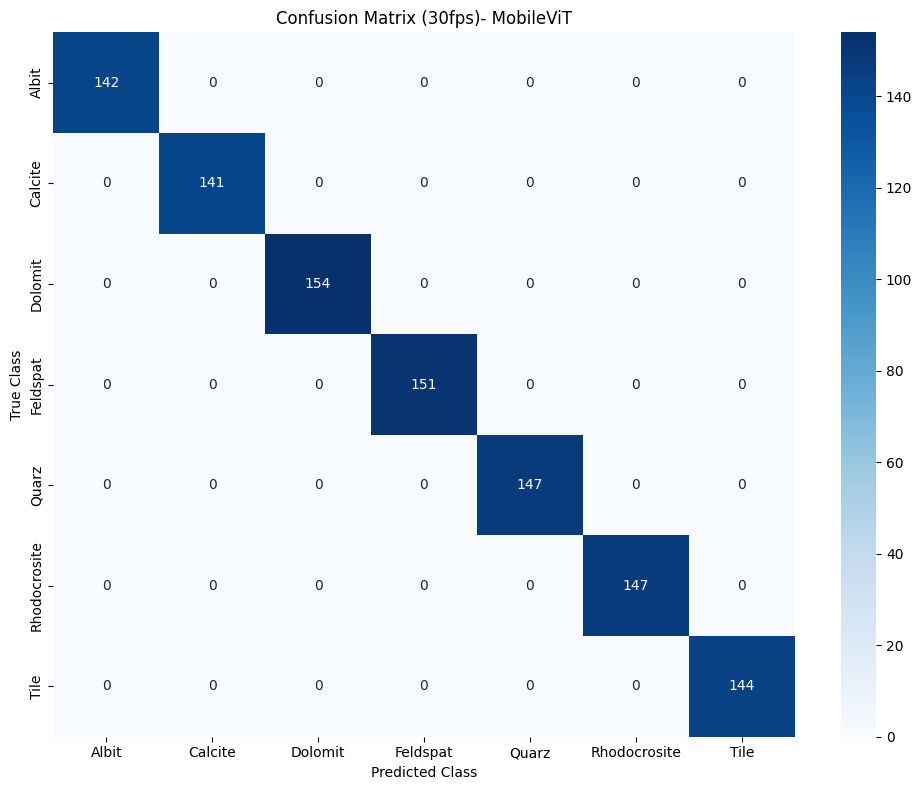

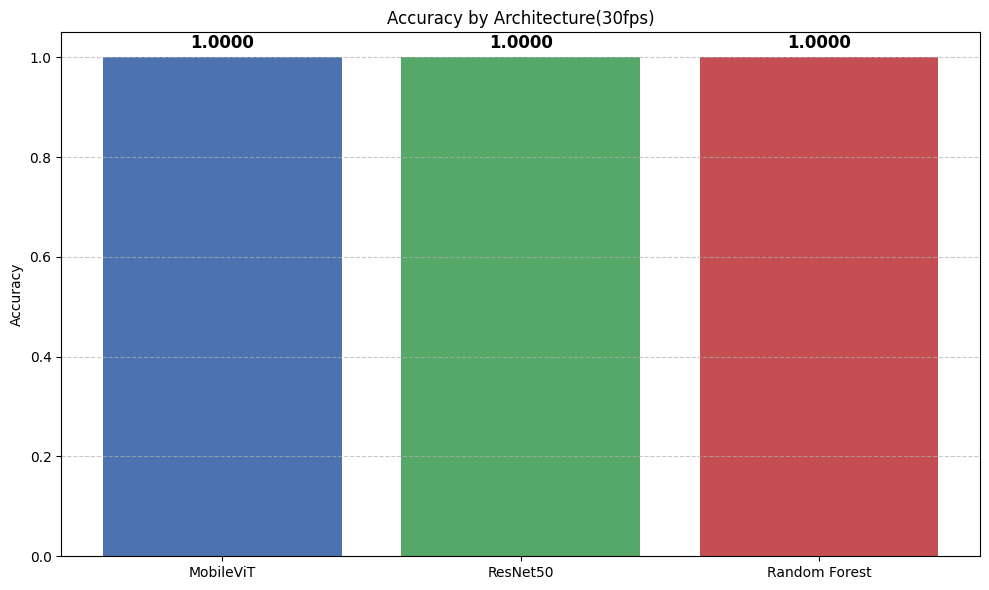

In [7]:
# --- 5. Evaluation & Visualization ---


print("\n--- Final Results ---")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")


best_model_name = max(results, key=results.get)
best_acc = results[best_model_name]
best_preds = predictions[best_model_name]

print(f"\n🏆 Best Performing Model: {best_model_name} ({best_acc:.4f})")

# 2. Classification Report for Best Model

print(f"\nClassification Report for {best_model_name}:")
print(classification_report(test_labels, best_preds, target_names=CLASS_NAMES))

# 3. Confusion Matrix for Best Model
cm = confusion_matrix(test_labels, best_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix (30fps)- {best_model_name}')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.savefig('../results/confusion_matrix_images_30fps.png')
plt.show()

# 4. Bar Chart Comparison
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = list(results.values())

bars = plt.bar(model_names, accuracies, color=['#4c72b0', '#55a868', '#c44e52'])
plt.title('Accuracy by Architecture(30fps)')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05) 


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('../results/accuracy_comparison_images_30fps.png')
plt.show()

In [8]:
# --- Save Models ---
import joblib 
print("\n--- Saving Models ---")
torch.save(mobilevit_model.state_dict(), '../models/model_mobilevit_images_30fps.pth')
torch.save(resnet_model.state_dict(), '../models/model_resnet50_images_30fps.pth')
joblib.dump(rf_clf, '../models/model_rf_images_30fps.joblib')
print("Models saved in ../models/")


--- Saving Models ---
Models saved in ../models/
